# Xpand IT DS Challenge

## Configuration

### Import Packages

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Configure pyplot and seaborn

In [3]:
# If set, put axes ticks and the gridlines below the plots
plt.rc("axes", axisbelow=True)

# [NOTE: seaborn uses matplotlib's rc (runtime configuration) and, therefore, there is
# no need to configure Seaborn's rc in particular.]

### Define a DataFrame Styling Function

In [28]:
def style_df(df, caption=""):
    return (df.style
        .set_caption(caption)
        .set_table_styles([
            {
                "selector": "caption",
                "props": [
                    ("width", "100%"),
                    ("font-size", "16px"),
                    ("font-weight", "bold"),
                    ("font-style", "italic"),
                    ("text-align", "left"),
                    ("padding-top", "15pt"),
                    ("padding-bottom", "5pt"),
                    ("padding-left", "15pt")
                ]
            },
            {
                "selector": "td",
                "props": [
                    ("padding-bottom", "10pt")
                    ] 
            }
        ])
    )

## Business Analysis

### What is the Dow Jones Index?
The Dow Jones Index, also called **Dow Jones Industrial Average**, is a stock market index that rates the combination of $30$ prominent companies of the United States of America. It is based on the values of the stock shares of each of these $30$ companies. Its computation formula corresponds to

$$
\mathrm{DJIA} = \frac{\sum_{i} p_i}{d}\text{ ,}
$$

where $p_i$ is the price of a single stock share of the $i$-th company and $d$ is the so-called **Dow Divisor**. This divisor is adjusted in case of stock splits, spinoffs or similar structural changes. On [$26^{\mathrm{th}}$ of February of $2024$](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average#Computation), its value corresponded to $0.15221633137872$.

The list of $30$ companies accounted by the index may actually change as these cease to be prominent, underperforming when compared to those companies "below" them. As of February of $26^{\mathrm{th}}$ of February of $2024$, the list has changed $58$ times. To ensure that the Dow Jones Index remains continuous in face of such change the Dow Divisor $d$ is updated accordingly.

### How does the issued data compares with the Dow Jones Index?

The issued data does not correspond to the Dow Jones Index, but contains all the necessary data for computing it except the Dow Divisor (although out-of-the-scope for this project, and no table has been found, the present author believes that a more thorough search could be successful in retrieving Dow Divisor's historic values). The data is comprised by the stock share values of the $30$ prominent companies at the different weeks of the first two quarters of $2011$, plus some additional and useful info, such as **volume of exchanged  shares**, and **dividend yields**. 

* The **volume of exchanged shares** may describe the liquidity of the market (high values would make buying or selling shares to not significantly affect the stock's price), the stock price "momentum" (spikes in exchanged volume might start new trends) as well as the investor "sentiment" (high values indicate high interest and confidence in the stock);

* Companies may pay at certain times an amount to a shareholder based on the amount of shares held and a stipulated factor: the **dividend yield**. This corresponds to the ratio between the value of the dividend payment per stock share and the value of that same stock share. High values are usually associated with a high profitability and management confidence of the company, promoting further reinvestment by the shareholders, which could then increase the stock value.

[***NOTE:*** if the so-called ex-dividend dates were issued together with the data, one could have actually considered the dividend return to be part of the profit of the investor in the current problem. Since they were not, the computed profit was solely based on the relative change of the stock prices.]

All of these data are important for building a model that could reliably predict the evolution of the stock prices.

## Data Understanding
During the data understanding phase, you should focus on understanding what each variable represents, compute statistics and visualizations. Some questions that may guide your work follow:
* Feature engineering: should new features be created from the existing ones?
* What will be your features and your label?
* Is the dataset ready for the prediction task? (ex: missing values)
* How will the data be split into train and test sets?

-----

`percent_change_price` corresponds to the relative difference of the stock price between end and beginning of the working week, that is, 

$$\mathrm{percent\_change\_price} = \frac{\text{close} - \text{open}}{\text{open}} \times 100 \,\%\text{ .}$$

$$\mathrm{percent\_change\_volume\_over\_last\_wk} = \frac{\text{volume} - \text{previous\_weeks\_volume}}{\text{previous\_weeks\_volume}} \times 100 \,\%\text{ .}$$

### Import the data

In [55]:
data = pd.read_csv("data/dow_jones_index.data")
display(style_df(df=data.head(), caption="Raw data"))

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.792670,nan,nan,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.428490,1.380223,239655616.000000,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.470660,-43.024959,242963398.000000,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.638310,9.355500,138428495.000000,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.933250,1.987452,151379173.000000,$17.33,$17.37,0.230814,97,0.175029


###  Handling missing values

### Transform, create and drop data

* **Column `quarter`:** 

    * It has the year quarter numbers (either $1$ or $2$) in thee respective weeks;

    * **The column is to be used for process-wise data batching (value $1$ for training and $2$ for test).**

    * [***Note:*** to assert the predictability of the model for far future events, the second quarter is to be used as test, and the first for training (in similarity to what was done in the [article cited by challenge's GitHub page](https://link.springer.com/chapter/10.1007/978-3-642-39712-7_3)).]

* **Column `stock`:**
    * It has the acronyms that identify stock's company.

    * **The column is to be used for company-wise data splitting (value "MMM" for company 3M, "AXP" for American Express, ...);**

    * [***Note:*** since a model is to be created per company, the data needs to be split by company.]

* **Column `date`:** 

    * It has the dates for the closing of the stock exchange in the respective weeks. **One should not directly use dates as features since they comprise a very large number of categories, whose some part may be "seen" during training but not during testing, inducing overfitting. For instance, by training with the data of the first quarter and testing with the data of the second, if the dates are used as features, the training cases would be supported but the testing ones not at all and extrapolation would occur.** However, if elements of the dates are seen in both batches (usually cyclic elements, such as the weekday, month, etc.) these could be used as features in place of the dates. In the current problem, the range of dates would not allow a proper usage of the common date cyclic elements. **Still, one could think on using an "artificial" cycling element, such as the part of the month: $1$ for firsth thirth (beginning), $2$ for second thirth (middle) and $3$ for last tirth (ending). For instance, a month with 31 days would have the values $1$ for days $1-10$, 2 for days $11-20$ and 3 for days $21-31$. Let `part_of_the_month` be the resultant new column.**

    * **The column `date` is to be used as <ins>data identifier (row index)</ins>.**

    * **The new colum `part_of_the_month` is to be used as feature.**

    <br>

* **Columns `open`, `high`, `low`, `close` and `percent_change_price`:**

    * The first four have the value per share of the stocks at the opening, best day, worse day and closing of the market at that week, respectively. They are formatted as strings and prefixed by the american dollar "$\$$". **To properly handle them, they should be converted to floats;**

    * Also, since column `percent_change_price` (relative difference (in percentage) between closing and opening values) are simply obtained from  `open` and `close` one of the columns would be redudant;

    * **The column `close` is to be dropped;**

    * **The resultant other columns are to be used as <ins>features</ins>.**

    <br>
    
* **Columns `volume`, `percent_change_volume_over_last_wk` and `previous_weeks_volume`:**

    * Since `percent_change_volume_over_last_wk` (relative difference (in percentage) of exchanged volume of stock shares between current and previous week) are obtained from `previous_weeks_volume` and `volume`, one should disregard one of the columns;

    * **The column `previous_weeks_volume` is to be dropped;**
    
    * **The other columns are to be used as <ins>features</ins>.**

    <br>

* **Columns `next_weeks_open`, `next_weeks_close` and `percent_change_next_weeks_price`:**

    * Since `percent_change_next_weeks_price` (relative difference (in percentage) between closing and opening stock values of the future week) are obtained from `next_weeks_open` and `next_weeks_close`, one of them needs to be dropped;
    
    * **The column `next_weeks_close` is to be dropped;**
    
    * **The column `next_weeks_open` is to be used as <ins>feature</ins>;**

    * **The column `percent_change_next_weeks_price` is to be used as <ins>target</ins>.**

    <br>

* **Columns `days_to_next_dividend` and `percent_return_next_dividend`:**

    *  The former is the number of days from current week to the day of the next dividend payment. The latter is the ratio (in percentage) between the value of the dividend payment per stock share and the value of that same stock share, based on the state of the current week;
    
    * **The columns are to be used as <ins>features</ins>.**

* **New column `percent_change_break_price`:**
    * It would be important to also use as the variation of the stock share value during the break between current and future weeks (usually the weekend). One could then use columns `close` and `next_weeks_open` to compute the relative difference (in percentage) between next opening and current closing values, herein termed as `percent_change_break_price`:

    $$
    \mathrm{percent\_change\_break\_price} = \frac{\mathrm{next\_weeks\_open} - \mathrm{close}}{\mathrm{close}} \times 100\, \%\text{ .}
    $$

    * **The resultant column is to be used as <ins>feature</ins>.**

The total number of features is $12$. And the number of targets is $1$.

### Exploratory data analysis

In [131]:

# ---> Define cuatom histogram plotting function
def hisplot_custom(
    df,
    col,
    # Data type to which the column is to be transformed
    col_dtype=str,
    stat="count",
    bins=20,
    shrink=1.0,
    bar_label=True,
    bar_label_rotation=0,
    xticklabels_rotation=0,
):
    
    # Initialise figure and axes
    plt.figure(figsize=(9, 6))
    ax = plt.axes()
    plt.title(
        "Occurrence" + 
        (" fractions " if stat == "percent" else " counts ") +
        "per value" +
        (" " if stat == "percent" else " range ") + f"in column \"{col}\"",
        pad=20
    )


    # Define bar plot
    sns.histplot(
        ax=ax,
        data=df.astype({col: col_dtype}),
        x=col,
        stat=stat,
        bins=bins,
        shrink=shrink,
        edgecolor="black",
        alpha=1,
        color="blue",
        linewidth=1.0,
    )

    if bar_label == True:
        # Plot bars' values
        for container in ax.containers:
            ax.bar_label(
                container=container,
                padding=2,
                fmt=r"${:.2f}\,\%$" if stat == "percent" else r"${:.0f}$",
                size=9,
                rotation=bar_label_rotation
            )

    # Define axes labels                                
    ax.set_xlabel(col, fontdict={"fontsize": 10})
    ax.set_ylabel(
        r"Fraction $[\%]$" if stat == "percent" else r"Count",
        fontdict={"fontsize": 10}
    )

    # Define axes ticks
    ax.tick_params(axis="x", rotation=xticklabels_rotation)

    # Define axes ranges
    ax.set_ylim(top=1.1 * ax.get_ylim()[1])

    # Enable axes' minor ticks
    ax.minorticks_on()

    # Define grid
    ax.grid(
        visible=True,
        which="major",
        color="lightgray",
        linestyle="solid",
        linewidth=0.5
    )
    ax.grid(
        visible=True,
        which="minor",
        color="lightgray",
        linestyle="dotted",
        linewidth=0.5
    )
    
    # Show plot
    plt.show() 

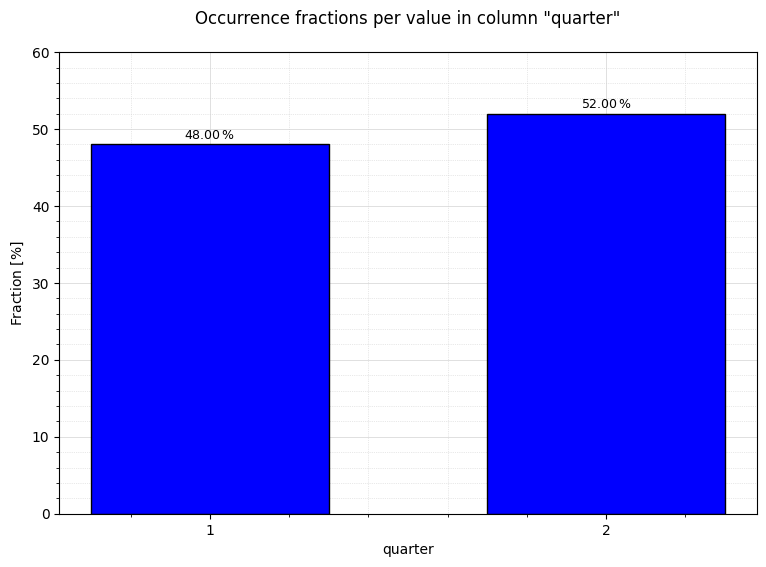

In [139]:
hisplot_custom(df=data, col="quarter", col_dtype=str, stat="percent", shrink=0.6)

-----
*Add here your data understanding findings and conclusions (max. 200 words)*

-----

## Modelling
In this phase, your main goal is to develop and describe your approach to the solution of the problem. Some guidelines to help you:
* What metrics will you use to evaluate your solutions?
* What are some algorithms that can lead to good results? And why?
* Describe in detail your thought process during the development of your solution.
* Present your results.


-----


In [ ]:
#add here your modelling code

-----
*Add here your modelling results and conclusions (max. 200 words)*

-----

## Conclusions
In the conclusions, you should enumerate the results you got after completing the challenge.
* How good do you consider your results? 
* What are some factors that would contribute to get better results?
* What are some advantages and disadvantages of your solution?
* What can be done as future work to improve your results?


-----
*Add here your final conclusions (max. 400 words)*

-----

#### Feedback

-----
*Add here your thoughts and feedback regarding this challenge.*

-----

To submit your solution you should e-mail us this notebook in response to the e-mail you initially received with the challenge.